### Lesson 6 pets
* Load data
* Do data augmentation and plot
* Train model
* Create prediction heatmap

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [15]:
bs = 64

In [16]:
path = untar_data(URLs.PETS)/'images'

In [17]:
tfms_base = get_transforms()
tfms_extra = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [18]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [20]:
def get_data(tfms, size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [22]:
data_base = get_data(tfms_base, 224, bs, 'zeros')
data_extra = get_data(tfms_extra, 224, bs, 'zeros')

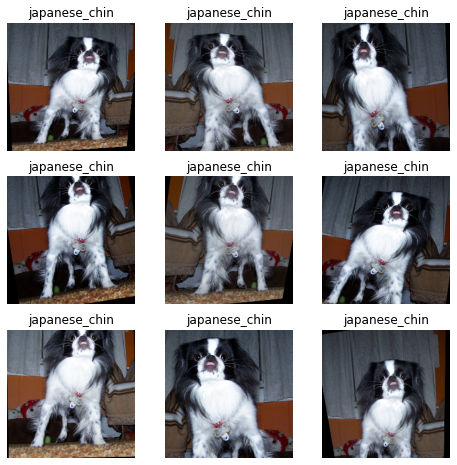

In [23]:
def _plot_base(i,j,ax):
    x,y = data_base.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot_base, 3, 3, figsize=(8,8))

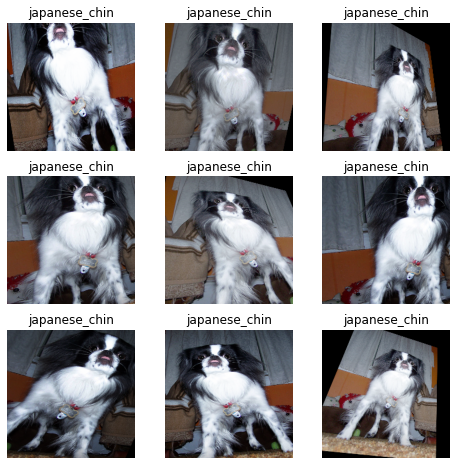

In [24]:
def _plot_extra(i,j,ax):
    x,y = data_extra.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot_extra, 3, 3, figsize=(8,8))

In [25]:
data_base = get_data(tfms_base, 224,bs)
data_extra = get_data(tfms_extra, 224,bs)

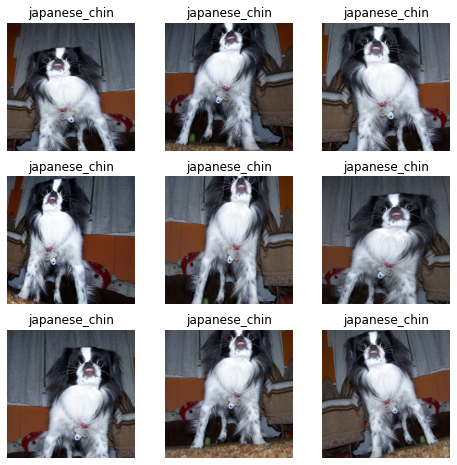

In [26]:
plot_multi(_plot_base, 3, 3, figsize=(8,8))

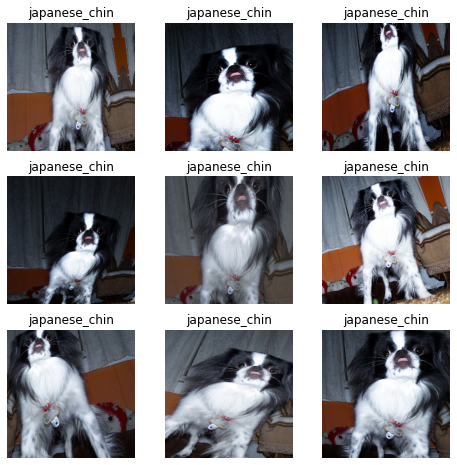

In [27]:
plot_multi(_plot_extra, 3, 3, figsize=(8,8))

In [29]:
gc.collect()
learn = cnn_learner(data_extra, models.resnet34, metrics=error_rate, bn_final=True)

In [30]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.631368,0.359236,0.086604,00:17
1,0.968015,0.288109,0.091340,00:14
2,0.727847,0.255349,0.078484,00:14


In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.578852,0.253944,0.073748,00:19
1,0.549958,0.241891,0.067659,00:19


In [32]:
data_extra = get_data(tfms_extra, 352,bs)
learn.data = data_extra

In [33]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.534924,0.220099,0.049391,00:43
1,0.479828,0.217366,0.050068,00:41


In [34]:
learn.save('352')

### Conv kernel

Category american_pit_bull_terrier

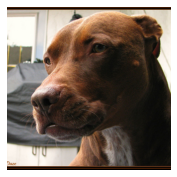

In [37]:
idx=0
x,y = data_extra.valid_ds[idx]
x.show()
data_extra.valid_ds.y[idx]

In [38]:
k = tensor([
    [-1., 0., 1.],
    [-2., 0., 2.],
    [-1., 0., 1.]]).expand([1, 3, 3, 3])
k

tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])

In [40]:
k.shape

torch.Size([1, 3, 3, 3])

In [51]:
xb = x.data[None]
xb.shape

torch.Size([1, 3, 352, 352])

In [57]:
xk = F.conv2d(xb, k)
xk.shape

torch.Size([1, 1, 350, 350])

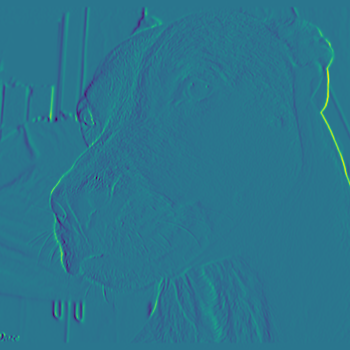

In [58]:
Image(xk.reshape(xk.shape[1:]))

In [66]:
xkt = F.conv2d(xb, k.transpose(2,3))
xkt.shape

torch.Size([1, 1, 350, 350])

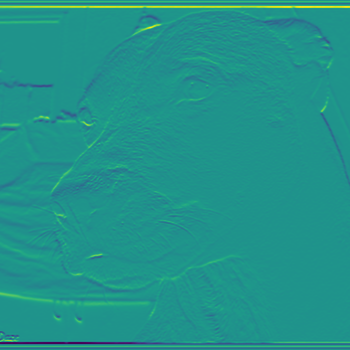

In [68]:
Image(xkt.reshape(xkt.shape[1:]))

### Heatmap

In [75]:
learn.model.eval();

In [77]:
xb, _ = data_extra.one_item(x)
xb.shape

torch.Size([1, 3, 352, 352])

torch.Size([1, 3, 352, 352])


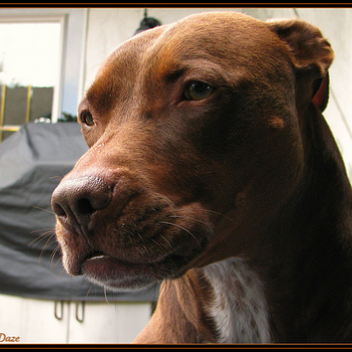

In [123]:
xb_denorm = data_extra.denorm(xb)
print(xb_denorm.shape)
xb_denorm_img = Image(xb_denorm[0])
xb_denorm_img

In [96]:
xb[0,0,:3,:3]

tensor([[-2.1179, -2.1179, -2.1179],
        [-2.1179, -2.1179, -2.1179],
        [-2.0920, -2.0920, -2.0920]], device='cuda:0')

In [97]:
xb_denorm[0,0,:3,:3]

tensor([[1.1921e-07, 1.1921e-07, 1.1921e-07],
        [1.1921e-07, 1.1921e-07, 1.1921e-07],
        [5.9418e-03, 5.9418e-03, 5.9418e-03]])

In [100]:
(xb.min(), xb.max())

(tensor(-2.1179, device='cuda:0'), tensor(2.6359, device='cuda:0'))

In [108]:
(xb_denorm.min(), xb_denorm.max())

(tensor(5.9605e-08), tensor(1.0000))

In [109]:
m = learn.model.eval();

In [110]:
from fastai.callbacks.hooks import *
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [111]:
hook_a,hook_g = hooked_backward()

In [112]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [115]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [121]:
def show_heatmap(xb, hm):
    _,ax = plt.subplots()
    xb.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

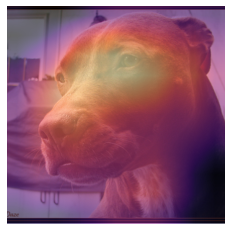

In [124]:
show_heatmap(xb_denorm_img, avg_acts)

In [127]:
grads = hook_g.stored[0].cpu()[0]
grads.shape

torch.Size([512, 11, 11])

In [128]:
avg_grads = grads.mean(0)
avg_grads.shape

torch.Size([11, 11])

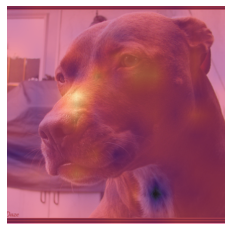

In [143]:
show_heatmap(xb_denorm_img, avg_grads)

In [129]:
xb.shape

torch.Size([1, 3, 352, 352])

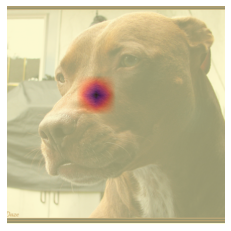

In [152]:
show_heatmap(xb_denorm_img, avg_acts // avg_grads)

In [141]:
avg_acts.max()

tensor(1.7749)